In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, '../src/')
import zivkovic as z
import coalescentmoments as c
import helpers as h

In [3]:
def readsim(fn):
    times = None
    sizes = None
    with open(fn) as infile:
        while True:
            line = infile.readline()
            if not line.startswith("#"):
                break
            elif line.startswith("#DEMOCHANGE_TIMES"):
                times = np.array(line.split("=")[1].split(','), dtype=float)
            elif line.startswith("#DEMOCHANGE_SIZES"):
                sizes = np.array(line.split("=")[1].split(','), dtype=float)
            print(line.strip())

        sfs = np.array(line.split(), dtype=float)
        twosfs = np.zeros((len(sfs), len(sfs)))
        twosfs[np.triu_indices_from(twosfs)] = np.array(infile.readline().split(), dtype=float)
        
    twosfs[np.diag_indices_from(twosfs)] /= 2
    twosfs += np.transpose(twosfs)
    
    # print(h.sfs2pi((sfs + sfs[::-1])[:50], 100))
    sfs /= np.sum(sfs)
    twosfs /= np.sum(twosfs)
    return sfs, twosfs, times, sizes

In [4]:
def lump_sfs(sfs, bmax):
    sfs_lumped = np.zeros(bmax+1)
    sfs_lumped[:bmax] = sfs[:bmax]
    sfs_lumped[bmax] = sum(sfs[bmax:])
    return(sfs_lumped)

def lump_2sfs(twosfs, bmax):
    lumped = np.zeros((bmax+1, bmax+1))
    lumped[:bmax,:bmax] = twosfs[:bmax,:bmax]
    lumped[bmax,:bmax] = np.sum(twosfs[bmax:,:bmax],axis=0)
    lumped[:bmax, bmax] = np.sum(twosfs[:bmax:, bmax:],axis=1)
    lumped[bmax, bmax] = np.sum(twosfs[bmax:,bmax:])
    return(lumped)

def kldiv(p, q):
    return - np.sum(p*np.log2(q/p))


In [5]:
n = 100
alpha = 1.5
model = "4EpochConst"
xibeta_fn = "../simulations/msprime/jsfs_n-{}_xibeta-{}_r-0.0.txt".format(n, alpha)
kingman_fn = "../simulations/msprime/jsfs_fastNeutrino-xibeta_n-{}_alpha-{}_{}_r-0.0.txt".format(n,alpha,model)

sfs_xibeta, twosfs_xibeta, _, _ = readsim(xibeta_fn)
sfs_kingman, twosfs_kingman, times, sizes = readsim(kingman_fn)

#N_SAMPLES=100
#N_LOCI=100000
#Tc=1
#SFS_FROM=TREES
#RECOMBINATION_RATE=0.0
#GROWTH_RATE=0.0
#ALPHA=2.0
#N_SAMPLES=100
#N_LOCI=100000
#Tc=1
#SFS_FROM=TREES
#RECOMBINATION_RATE=0.0
#GROWTH_RATE=0.0
#ALPHA=2.0
#DEMOCHANGE_TIMES=0.0,0.011344741692743894,0.4766063224638619,0.6913860170475844
#DEMOCHANGE_SIZES=1.0,0.1662508802089224,0.9772907335993951,7.468952737961113


[0.         0.01134474 0.47660632 0.69138602] [1.         0.16625088 0.97729073 7.46895274]


Text(0.5, 0, 'Time ($t / N_0)$')

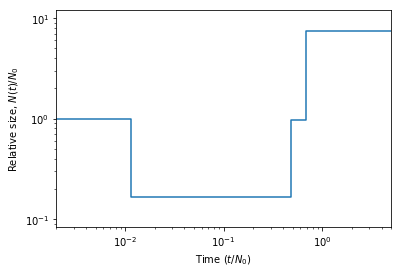

In [6]:
print(times, sizes)
plt.loglog(list(times) + [5.0] , list(sizes) + [sizes[-1]], drawstyle="steps-post")
plt.xlim([1/500, 5])
plt.ylim([1/12,12])
plt.ylabel('Relative size, $N(t)/N_0$')
plt.xlabel('Time ($t / N_0)$')

Text(0.5, 0, 'Derived allele count')

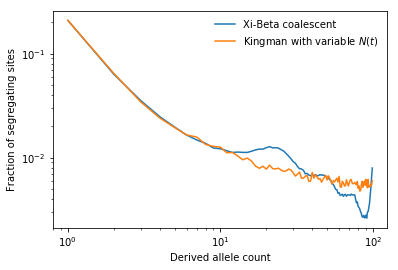

In [7]:
plt.loglog(np.arange(1,n), sfs_xibeta/np.sum(sfs_xibeta), label="Xi-Beta coalescent")
plt.loglog(np.arange(1,n), sfs_kingman/np.sum(sfs_kingman), label="Kingman with variable $N(t)$")
plt.legend()
plt.ylabel("Fraction of segregating sites")
plt.xlabel("Derived allele count")

In [8]:
lump_cutoff = 10
lumped_sfs_xibeta = lump_sfs(sfs_xibeta, lump_cutoff)
lumped_sfs_kingman = lump_sfs(sfs_kingman, lump_cutoff)
lumped_2sfs_xibeta = lump_2sfs(twosfs_xibeta, lump_cutoff)
lumped_2sfs_kingman = lump_2sfs(twosfs_kingman, lump_cutoff)

In [9]:
print(np.min(lumped_2sfs_kingman))

2.7909543861620327e-05


In [10]:
pmi_xibeta = np.log2(lumped_2sfs_xibeta / (lumped_sfs_xibeta[:,None]*lumped_sfs_xibeta[None,:]))
pmi_kingman = np.log2(lumped_2sfs_kingman / (lumped_sfs_kingman[:,None]*lumped_sfs_kingman[None,:]))

Text(0.5, 0, 'Derived allele count')

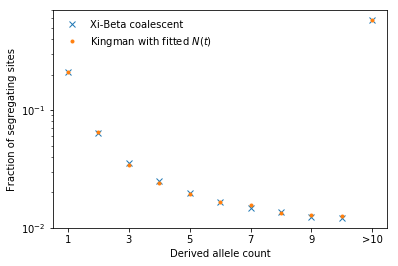

In [11]:
ax = plt.subplot(111)
ax.semilogy(np.arange(1,12), lumped_sfs_xibeta, 'x', label="Xi-Beta coalescent")
ax.semilogy(np.arange(1,12), lumped_sfs_kingman, '.', label="Kingman with fitted $N(t)$")
ax.set_xticks([1,3,5,7,9,11])
ax.set_xticklabels([1,3,5,7,9,">10"])
plt.legend()
plt.ylabel("Fraction of segregating sites")
plt.xlabel("Derived allele count")

In [12]:
kldiv(lumped_2sfs_kingman, lumped_2sfs_xibeta)

0.3999480538827186

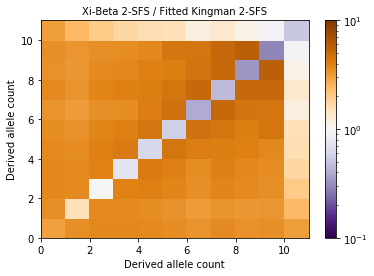

In [13]:
import matplotlib.colors as colors
plt.pcolormesh(lumped_2sfs_xibeta/lumped_2sfs_kingman,
               norm=colors.LogNorm(vmin=0.1, vmax=10),
               cmap="PuOr_r")
plt.ylabel("Derived allele count")
plt.xlabel("Derived allele count")
plt.title("Xi-Beta 2-SFS / Fitted Kingman 2-SFS")
plt.colorbar()

In [14]:
print(kldiv(lumped_2sfs_kingman, lumped_2sfs_xibeta))

0.3999480538827186


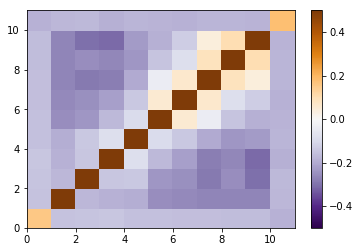

In [15]:
plt.pcolormesh(pmi_xibeta, vmin=-0.5, vmax=0.5, cmap='PuOr_r')
plt.colorbar()

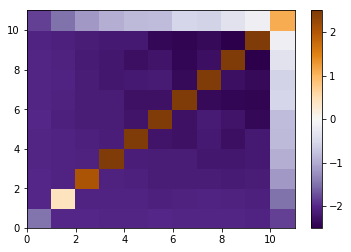

In [16]:
plt.pcolormesh(pmi_kingman, vmin=-2.5, vmax=2.5, cmap='PuOr_r')
plt.colorbar()

In [17]:
xibeta_fn = "../simulations/msprime/jsfs_n-{}_xibeta-{}_r-1.0.txt".format(n, alpha)
kingman_fn = "../simulations/msprime/jsfs_fastNeutrino-xibeta_n-{}_alpha-{}_{}_r-3.0.txt".format(n,alpha,model)

sfs_xibeta, twosfs_xibeta, _, _ = readsim(xibeta_fn)
sfs_kingman, twosfs_kingman, times, sizes = readsim(kingman_fn)

lumped_sfs_xibeta = lump_sfs(sfs_xibeta, lump_cutoff)
lumped_sfs_kingman = lump_sfs(sfs_kingman, lump_cutoff)
lumped_2sfs_xibeta = lump_2sfs(twosfs_xibeta, lump_cutoff)
lumped_2sfs_kingman = lump_2sfs(twosfs_kingman, lump_cutoff)

#N_SAMPLES=100
#N_LOCI=100000
#Tc=1
#SFS_FROM=TREES
#RECOMBINATION_RATE=1.0
#GROWTH_RATE=0.0
#ALPHA=2.0
#N_SAMPLES=100
#N_LOCI=100000
#Tc=1
#SFS_FROM=TREES
#RECOMBINATION_RATE=3.0
#GROWTH_RATE=0.0
#ALPHA=2.0
#DEMOCHANGE_TIMES=0.0,0.011344741692743894,0.4766063224638619,0.6913860170475844
#DEMOCHANGE_SIZES=1.0,0.1662508802089224,0.9772907335993951,7.468952737961113


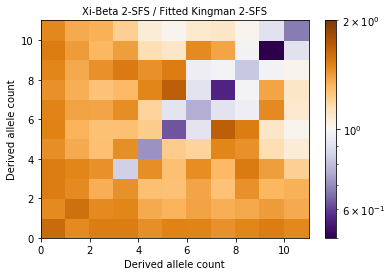

In [18]:
plt.pcolormesh(lumped_2sfs_xibeta/lumped_2sfs_kingman,
               norm=colors.LogNorm(vmin=0.5, vmax=2),
               cmap="PuOr_r")
plt.ylabel("Derived allele count")
plt.xlabel("Derived allele count")
plt.title("Xi-Beta 2-SFS / Fitted Kingman 2-SFS")
plt.colorbar()

In [19]:
print(kldiv(lumped_2sfs_kingman, lumped_2sfs_xibeta))

0.09691475273919559


In [20]:
RS = np.insert(np.logspace(-1, 3, 13), 0, 0.0)
print(3*RS)
n_rs = 8
kldivs = np.zeros(n_rs)
for i, r in enumerate(RS[:n_rs]):
    xibeta_fn = "../simulations/msprime/jsfs_n-{}_xibeta-{}_r-{}.txt".format(n, alpha, r)
    kingman_fn = "../simulations/msprime/jsfs_fastNeutrino-xibeta_n-{}_alpha-{}_{}_r-{}.txt".format(n,alpha,model,3*r)

    sfs_xibeta, twosfs_xibeta, _, _ = readsim(xibeta_fn)
    try:
        sfs_kingman, twosfs_kingman, times, sizes = readsim(kingman_fn)

        lumped_2sfs_xibeta = lump_2sfs(twosfs_xibeta, lump_cutoff)
        lumped_2sfs_kingman = lump_2sfs(twosfs_kingman, lump_cutoff)
    
        kldivs[i] = kldiv(lumped_2sfs_kingman, lumped_2sfs_xibeta)
    except:
        pass

[0.00000000e+00 3.00000000e-01 6.46330407e-01 1.39247665e+00
 3.00000000e+00 6.46330407e+00 1.39247665e+01 3.00000000e+01
 6.46330407e+01 1.39247665e+02 3.00000000e+02 6.46330407e+02
 1.39247665e+03 3.00000000e+03]
#N_SAMPLES=100
#N_LOCI=100000
#Tc=1
#SFS_FROM=TREES
#RECOMBINATION_RATE=0.0
#GROWTH_RATE=0.0
#ALPHA=2.0
#N_SAMPLES=100
#N_LOCI=100000
#Tc=1
#SFS_FROM=TREES
#RECOMBINATION_RATE=0.0
#GROWTH_RATE=0.0
#ALPHA=2.0
#DEMOCHANGE_TIMES=0.0,0.011344741692743894,0.4766063224638619,0.6913860170475844
#DEMOCHANGE_SIZES=1.0,0.1662508802089224,0.9772907335993951,7.468952737961113
#N_SAMPLES=100
#N_LOCI=100000
#Tc=1
#SFS_FROM=TREES
#RECOMBINATION_RATE=0.1
#GROWTH_RATE=0.0
#ALPHA=2.0
#N_SAMPLES=100
#N_LOCI=100000
#Tc=1
#SFS_FROM=TREES
#RECOMBINATION_RATE=0.30000000000000004
#GROWTH_RATE=0.0
#ALPHA=2.0
#DEMOCHANGE_TIMES=0.0,0.011344741692743894,0.4766063224638619,0.6913860170475844
#DEMOCHANGE_SIZES=1.0,0.1662508802089224,0.9772907335993951,7.468952737961113
#N_SAMPLES=100
#N_LOCI=100000
#Tc=1

Text(0.5, 1.0, 'Xi-Beta vs. Kingman 2-SFS')

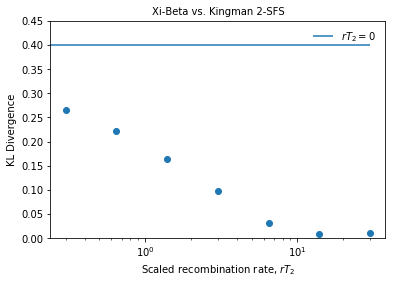

In [21]:
plt.semilogx(3*RS[:8], kldivs, 'o')
plt.hlines(kldivs[0], 0, 30, color="C0", label="$r T_2=0$")
plt.ylim([0,0.45])
plt.legend()
plt.ylabel("KL Divergence")
plt.xlabel("Scaled recombination rate, $r T_2$")
plt.title("Xi-Beta vs. Kingman 2-SFS")